# Draft of EKF implementation for temporal alignment

Using CTRA model.

Heavily based on [balzer82 implementation](https://github.com/balzer82/Kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb) and [giovannix adaptation](https://github.com/giovannix/kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb).

In [1]:
from sympy import symbols, Matrix, init_printing
from IPython.display import display

init_printing()

vs, psis, dpsis, dts, xs, ys, lats, lons, axs = symbols('v \psi \dot\psi T x y lat lon a')

hs = Matrix([[xs],
             [ys],
             [psis],
             [vs],
             [dpsis],
             [axs]])

state = Matrix([xs,ys,psis,vs,dpsis,axs])

# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Pdv =[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kdv= []
dstate=[]
x_noisy_measurement = []
y_noisy_measurement = []
x_predicted = []
y_predicted = []

In [2]:
def log_state_and_noises(iteration, state, predicted_state, noises, dt):
    updated_state_s, noise_s, sensors_std_s, = symbols('updated\_state noise sensors\_std')
    
    p_x, p_y, p_psi, p_v, p_dotpsi, p_a = symbols('\hat\ x \hat\ y \hat\ \psi \hat\ v \hat{\dot{\psi}} \hat\ a')
    predicted_state_matrix_s = Matrix([p_x, p_y, p_psi, p_v, p_dotpsi, p_a])
    predicted_state_s = symbols('predicted\_state')
    
    print(f'Iteration {iteration}, dt = {dt}:')
    print('='*100)
        
    display(Eq(
        predicted_state_s,
        Eq(
            predicted_state_matrix_s,
            Matrix(predicted_state),
            evaluate=False
        )
    ))
    
    print('-'*100)
    display(Eq(
        updated_state_s,
        Eq(state, Matrix(x), evaluate=False)
    ))
    
    print('*Noise included')  
    print('-'*100)
    
    display(Eq(
        Le(
            -sensors_std_s,
            Le(noise_s, sensors_std_s),
            evaluate=False
        ),
        Le(
            Matrix(-sensors_std),
            Le(Matrix(noises), Matrix(sensors_std), evaluate=False),
            evaluate=False
        )
    ))

    print('='*100)

In [3]:
import numpy as np
from numpy.random import default_rng
from sympy import Matrix, Eq, Le, Ge, symbols, init_printing
from copy import deepcopy
from IPython.display import display

init_printing()

STATE_SIZE = 6 # States
STATE_X_IDX, STATE_Y_IDX, STATE_YAW_IDX, STATE_VELOCITY_IDX, STATE_YAW_RATE_IDX, STATE_ACCELERATION_IDX = range(STATE_SIZE)

# Generated running the loop with correction commented, just with prediction
mock = np.array([
    [4.0, -2.0, 1.5707963267948966, 5.0, 0.4487989505128276, 4.0],
    [3.7538, 0.4616, 1.761, 6.6948, 0.4488, 4.0],
    [2.8449, 3.5203, 1.9512, 8.3896, 0.4488, 4.0],
    [1.0564, 6.6834, 2.2174, 8.8133, 0.6283, 1.0],
    [-1.627, 9.3919, 2.4836, 9.237, 0.6283, 1.0],
    [-5.0039, 11.3473, 2.7498, 9.237, 0.6283, 0.0],
    [-8.7762, 12.3455, 3.016, 9.237, 0.6283, 0.0],
    [-12.7749, 13.1978, 2.8496, 10.0844, -0.3927, 2.0],
    [-16.9109, 14.8321, 2.6832, 10.9318, -0.3927, 2.0],
    [-20.7895, 17.6414, 2.3504, 11.7792, -0.7854, 2.0],
    [-23.7432, 21.856, 2.0176, 12.6266, -0.7854, 2.0],
    [-26.3263, 27.2473, 2.0176, 15.5925, 0.0, 7.0],
    [-29.1809, 33.2053, 2.0176, 15.5925, 0.0, 0],
])

def predict(x, P, dt):
    noise_pos     = 0.5*8.8*dt**2  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    noise_course  = 0.1*dt # assume 0.1rad/s as maximum turn rate for the vehicle
    noise_velocity= 8.8*dt # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    noise_yawrate = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle
    noise_accel   = 0.5 # assume 0.5m/s2

    # TODO: Can be improved and calibratred
    Q = np.diag([noise_pos**2, noise_pos**2, noise_course**2, noise_velocity**2, noise_yawrate**2, noise_accel**2])

    if np.abs(x[STATE_YAW_RATE_IDX]) < 0.00001: # Driving straight
        x[STATE_YAW_RATE_IDX] = 0.00001

    x[STATE_X_IDX] = x[STATE_X_IDX] + (1 / x[STATE_YAW_RATE_IDX]**2) * \
        ( \
            (x[STATE_VELOCITY_IDX]*x[STATE_YAW_RATE_IDX] + x[STATE_ACCELERATION_IDX] * x[STATE_YAW_RATE_IDX] * dt) * np.sin(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX]* dt) \
            + x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt) \
            - x[STATE_VELOCITY_IDX] * x[STATE_YAW_RATE_IDX] * np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX]) \
        )

    x[STATE_Y_IDX] = x[STATE_Y_IDX] + (1 / x[STATE_YAW_RATE_IDX]**2) * \
        ( \
            (-x[STATE_VELOCITY_IDX]*x[STATE_YAW_RATE_IDX] - x[STATE_ACCELERATION_IDX] * x[STATE_YAW_RATE_IDX] * dt) * np.cos(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX]* dt) \
            + x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt) \
            + x[STATE_VELOCITY_IDX] * x[STATE_YAW_RATE_IDX] * np.cos(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX]) \
        )

    x[STATE_YAW_IDX] = (x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt + np.pi) % (2.0 * np.pi) - np.pi
    x[STATE_VELOCITY_IDX] = x[STATE_VELOCITY_IDX] + x[STATE_ACCELERATION_IDX] * dt 
    x[STATE_YAW_RATE_IDX] = x[STATE_YAW_RATE_IDX]
    x[STATE_ACCELERATION_IDX] = x[STATE_ACCELERATION_IDX]

    # Calculate the Jacobian of the Dynamic Matrix A
    a13 = ( \
      (-x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX]*np.sin(x[STATE_YAW_IDX]) \
      - x[STATE_ACCELERATION_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + (dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] \
      + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a14 = ( \
      (-x[STATE_YAW_RATE_IDX]*np.sin(x[STATE_YAW_IDX]) + x[STATE_YAW_RATE_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a15 = ( \
      ( \
        -dt*x[STATE_ACCELERATION_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + dt*(dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]) \
        * np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - x[STATE_VELOCITY_IDX]*np.sin(x[STATE_YAW_IDX]) + (dt*x[STATE_ACCELERATION_IDX] + x[STATE_VELOCITY_IDX]) \
        * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
      - 2*( \
        -x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] \
        * np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + (dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]) \
        * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**3 \
    ).item(0)

    a16 = ( \
      (dt*x[STATE_YAW_RATE_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - np.cos(x[STATE_YAW_IDX]) + np.cos(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a23 = ( \
      ( \
        -x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX] * np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX] * np.cos(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
        - (-dt * x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX]) * np.sin(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a24 = ( \
      (x[STATE_YAW_RATE_IDX] * np.cos(x[STATE_YAW_IDX]) - x[STATE_YAW_RATE_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a25 = ( \
      ( \
        dt * x[STATE_ACCELERATION_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - dt * (-dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX]) \
        * np.sin(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) + (-dt*x[STATE_ACCELERATION_IDX] - x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
      - 2*( \
        x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX] * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
        + (-dt * x[STATE_YAW_RATE_IDX] * x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**3 \
    ).item(0)

    a26 = ( \
      (-dt*x[STATE_YAW_RATE_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - np.sin(x[STATE_YAW_IDX]) + np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)
      
    JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                    [0.0, 1.0, a23, a24, a25, a26],
                    [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
  
    # Project the error covariance ahead
    P = JA*P*JA.T + Q

    return x, P


def correct(measurement, x, P, R):
    hx = x.copy()  # Not making any transformation and considering all the atributes are being measured

    # Identity because is assumed that for each attribute in state there exists a respective measurement attribute
    JH = np.eye(hx.shape[0])

    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurement.reshape(JH.shape[0], 1)
    y = Z - hx  # Innovation or Residual
    x = x + K*y

    # Update the error covariance
    P = (np.eye(STATE_SIZE) - K*JH)*P
            
    # TODO: Remove in main C++ code
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pdv.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kdv.append(float(K[5,0]))

    return x, P

if __name__ == '__main__':
    P = np.diag([10.0, 10.0, 10.0, 10.0, 10.0, 10.0])
    
    std_pos = 1.5 # standard deviation of positioning measurements
    std_speed = 1.0 # standard deviation of the speed measurements
    std_yawrate = 0.1 # standard deviation of the yawrate measurements
    std_yaw = 0.02 # standard deviation of the yaw measurements
    std_acc = 0.5 # standard deviation of the longitudinal acceleration

    R = np.diag([std_pos**2, std_pos**2, std_yaw**2, std_speed**2, std_yawrate**2, std_acc**2])

    initial_state = np.array([[4, -2, np.pi/2, 5, np.pi/7, 4]], dtype='float64').T
    x = deepcopy(initial_state)
      
    random_generator = default_rng()
    
#     dts = [random_generator.random() for _ in mock]
#     dts = [np.round(dt, 4) for dt in dts]
#     print(dts)
    dts = (0.4571, 0.5364, 0.1067, 0.5539, 0.0843, 0.0452, 0.017, 0.1824, 0.5568, 0.9355, 0.2909, 0.1086, 0.4237)
    
    measurements = deepcopy(mock)

    for i, (measurement, dt) in enumerate(zip(measurements, dts), 1):
        sensors_std = np.array([std_pos, std_pos, std_yaw, std_speed, std_yawrate, std_acc])
        
        # Adding noise
        noises = (random_generator.random() for _ in sensors_std)
        noises = np.array([n * 2*std - std for std, n in zip(sensors_std, noises)])  # Putting noises in std range
        measurement += noises
        
        x_noisy_measurement.append(measurement[STATE_X_IDX])
        y_noisy_measurement.append(measurement[STATE_Y_IDX])
    
        x_old = deepcopy(x)
       
        x, P = predict(x, P, dt)
        predicted_state = deepcopy(x)

        x, P = correct(measurement, x, P, R)

        log_state_and_noises(i, state, predicted_state, noises, dt)
        x_predicted.append(predicted_state[STATE_X_IDX])
        y_predicted.append(predicted_state[STATE_Y_IDX])

Iteration 1, dt = 0.4571:


                  ⎡     \hat x     ⎤   ⎡3.70947952675031 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢0.682997338756643⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.77594232707431 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢     6.8284      ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.448798950512828⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣       4.0       ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ 4.28479226883698 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢-0.663443041904964⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 1.58985193851502 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 4.19186657910901 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢0.529414857699954 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 3.75071790996175 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.227877224710587 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢                  ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢ 1.12530135811694 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢                  ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0189722004975925⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                  ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.890138281105176⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢                  ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0811718580162639⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢                  ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.24418418199472 ⎦   ⎣0.5 ⎦

Iteration 2, dt = 0.5364:


                  ⎡     \hat x     ⎤   ⎡3.81406463347434 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢2.07525981367292 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.87383006818527 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢6.20375166601249 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.529414857699954⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣3.75071790996175 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡2.98288864598973 ⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢1.99922811807199 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢1.75037012616334 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢6.61959148184533 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.471605823570717⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣3.66925297914651 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡ -1.37987394098796 ⎤   ⎡1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-1.5 ⎥   ⎢ 1.43048846163729  ⎥   ⎢1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.02⎥   ⎢-0.0188336816592081⎥   ⎢0.02
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-1.0 ⎥   ⎢-0.058094072977281 ⎥   ⎢1.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢0.0244711469405193 ⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-0.5 ⎦   ⎣-0.374810420234834 ⎦   ⎣0.5 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 3, dt = 0.1067:


                  ⎡     \hat x     ⎤   ⎡2.83488863440771 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢2.71112737737142 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.80069046753833 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢7.01110077472027 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.471605823570717⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣3.66925297914651 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡2.47128616997015 ⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢ 2.6827436569036 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢1.87912706759315 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢7.44913039656715 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.561933690831339⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣ 3.8279920939698 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.853936079813556 ⎤   ⎡1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-1.5 ⎥   ⎢-0.897072330738926 ⎥   ⎢1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.02⎥   ⎢-0.0183351536732908⎥   ⎢0.02
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-1.0 ⎥   ⎢-0.708580459775136 ⎥   ⎢1.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢ 0.089464412225634 ⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-0.5 ⎦   ⎣-0.0795241105361467⎦   ⎣0.5 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 4, dt = 0.5539:


                  ⎡     \hat x     ⎤   ⎡0.343453067631383⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢6.86719694259943 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢2.19038213894462 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢9.56945521741703 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.561933690831339⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣ 3.8279920939698 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡0.387764010588347⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢6.12830310990778 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢2.22064339927526 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢9.51556279053627 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.636015159133795⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣ 2.0800601169756 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.689457780670396 ⎤   ⎡1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-1.5 ⎥   ⎢ -1.05943317246233 ⎥   ⎢1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.02⎥   ⎢0.00529451692324962⎥   ⎢0.02
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-1.0 ⎥   ⎢ 0.718249083442325 ⎥   ⎢1.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢0.00938641223141949⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-0.5 ⎦   ⎣0.00556965890164929⎦   ⎣0.5 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 5, dt = 0.0843:


                  ⎡     \hat x     ⎤   ⎡-0.119159577295381⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 6.75937157205869 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 2.27425947719024 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 9.69091185839732 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.636015159133795 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 2.0800601169756  ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-1.20025662305465⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢7.37340493515547 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢2.38742135893526 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢9.06758169909352 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.76182493590327 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣ 1.2486866498714 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡ -1.38137261577913  ⎤   ⎡1.5
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-1.5 ⎥   ⎢ -0.723644938841837 ⎥   ⎢1.5
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.02⎥   ⎢-0.00586734668741647⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-1.0 ⎥   ⎢ -0.618364400715885 ⎥   ⎢1.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢ 0.0975058159064015 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-0.5 ⎦   ⎣ -0.263839900224146 ⎦   ⎣0.5

 ⎤
 ⎥
 ⎥
 ⎥
2⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 6, dt = 0.0452:


                  ⎡     \hat x     ⎤   ⎡-1.50469625404549⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢7.64967996727936 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢2.42185584603809 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢9.12402233566771 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.76182493590327 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.2486866498714 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-2.17547718739585⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢8.22052298259319 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢2.54786421356966 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢9.00970957857107 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.799249752509835⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣0.206891792812011⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡  1.2122954901129  ⎤   ⎡1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-1.5 ⎥   ⎢ -1.26557911185042 ⎥   ⎢1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.02⎥   ⎢0.0013530549910531 ⎥   ⎢0.02
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-1.0 ⎥   ⎢-0.417746087877106 ⎥   ⎢1.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢-0.0417715196339896⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-0.5 ⎦   ⎣-0.436752343776906 ⎦   ⎣0.5 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 7, dt = 0.017:


                  ⎡     \hat x     ⎤   ⎡-2.30303281907098⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢8.30536339247277 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢2.56145145936233 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢9.01322673904888 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.799249752509835⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣0.206891792812011⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-3.49783463123017 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 9.2703657359609  ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.68583778544629 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 9.29204607843411 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢ 0.83252611728277 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣0.0321075242814062⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡ 1.10857941869915  ⎤   ⎡1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-1.5 ⎥   ⎢ 0.824026021998136 ⎥   ⎢1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.02⎥   ⎢-0.0134112308063577⎥   ⎢0.02
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-1.0 ⎥   ⎢ 0.51782283671401  ⎥   ⎢1.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢-0.0861591164935991⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-0.5 ⎦   ⎣-0.0777804552317759⎦   ⎣0.5 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 8, dt = 0.1824:


                  ⎡     \hat x     ⎤   ⎡-5.07089615777527 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 9.8983391529157  ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 2.83769054923867 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 9.29790249086304 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢ 0.83252611728277 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣0.0321075242814062⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-6.56496340624263 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 10.6790646799546 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.83561184528471 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 9.77233262694874 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.153030102970575⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 1.43156593976912 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡ -0.342187869555294 ⎤   ⎡1.5
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-1.5 ⎥   ⎢ 0.893174140479817  ⎥   ⎢1.5
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.02⎥   ⎢-0.00253191332043304⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-1.0 ⎥   ⎢ -0.262802510105598 ⎥   ⎢1.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢-0.0360028791565841 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-0.5 ⎦   ⎣ 0.289988680516788  ⎦   ⎣0.5

 ⎤
 ⎥
 ⎥
 ⎥
2⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 9, dt = 0.5568:


                  ⎡     \hat x     ⎤   ⎡-11.8848259279597 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 12.6157886427895 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 2.7504046839507  ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 10.5694285422122 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.153030102970575⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.43156593976912 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-14.4403545774932 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 13.2416393601672 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.69261426050415 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 10.5595823022673 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.342120820814961⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 1.8852244872365  ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡ 0.14772361243681  ⎤   ⎡1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-1.5 ⎥   ⎢ -1.16925689296747 ⎥   ⎢1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.02⎥   ⎢0.00541449372002326⎥   ⎢0.02
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-1.0 ⎥   ⎢-0.394586962209025 ⎥   ⎢1.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢0.0458986568469406 ⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-0.5 ⎦   ⎣ 0.150408168623717 ⎦   ⎣0.5 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 10, dt = 0.9355:


                  ⎡     \hat x     ⎤   ⎡-23.1569600919828 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 19.3744559212529 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 2.37256023263176 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 12.3232098100771 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.342120820814961⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.8852244872365  ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-21.0345444549794 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 16.6065133116102 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.33743824925498 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 12.2400509861533 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.724251649911887⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 2.24993547880375 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.0277394080122888⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢                  ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-1.42149174204634 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢                  ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.013667957079336⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                  ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.460617780008684 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢                  ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0570145734052637⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢                  ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣0.484814553509475 ⎦   ⎣0.5 ⎦

Iteration 11, dt = 0.2909:


                  ⎡     \hat x     ⎤   ⎡-23.2729605035383 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 19.4883919065486 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 2.12675344429561 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 12.8945572169374 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.724251649911887⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 2.24993547880375 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-23.5180486843614 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 21.4090691422627 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.01917478682332 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 12.2670190578016 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.881638335529248⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 1.86425495965304 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.182034010820604 ⎤   ⎡1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-1.5 ⎥   ⎢ 1.48384075522929  ⎥   ⎢1.5 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.02⎥   ⎢-0.0189833700257598⎥   ⎢0.02
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-1.0 ⎥   ⎢-0.469606893882954 ⎥   ⎢1.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢-0.0971295957797839⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-0.5 ⎦   ⎣-0.376212500397427 ⎦   ⎣0.5 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 12, dt = 0.1086:


                  ⎡     \hat x     ⎤   ⎡-24.0413759822514 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 22.645562077394  ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 1.92342886358485 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 12.4694771464199 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.881638335529248⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.86425495965304 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-24.9145148381482⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢23.7467604576972 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢1.99403991031965 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢14.1815021401288 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢-0.31597221418076⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣5.04005513185614 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡ -0.106979634811098 ⎤   ⎡1.5
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-1.5 ⎥   ⎢ -1.46501213226578  ⎥   ⎢1.5
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.02⎥   ⎢0.00933150744917036 ⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-1.0 ⎥   ⎢ -0.608126941279642 ⎥   ⎢1.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢-0.0847338908990812 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-0.5 ⎦   ⎣-0.00811730250785081⎦   ⎣0.5

 ⎤
 ⎥
 ⎥
 ⎥
2⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 13, dt = 0.4237:


                  ⎡     \hat x     ⎤   ⎡-27.1570961478482⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢29.8010528632176 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.86016248317126 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢16.3169734994962 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.31597221418076⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣5.04005513185614 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ -27.7782231083535 ⎤
                ⎢        ⎥   ⎢                   ⎥
                ⎢   y    ⎥   ⎢ 31.6370987167263  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢  \psi  ⎥   ⎢ 1.99534339013092  ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                   ⎥
                ⎢   v    ⎥   ⎢ 15.7459344830959  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢\dot\psi⎥   ⎢-0.0234678975694068⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎣   a    ⎦   ⎣ 2.08731357228555  ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡  0.88378442548135  ⎤   ⎡1.5
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-1.5 ⎥   ⎢  1.43844627385354  ⎥   ⎢1.5
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.02⎥   ⎢-0.00633539132466362⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-1.0 ⎥   ⎢  0.12016646781113  ⎥   ⎢1.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢-0.0140462105490189 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-0.5 ⎦   ⎣ 0.250776788571099  ⎦   ⎣0.5

 ⎤
 ⎥
 ⎥
 ⎥
2⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

In [4]:
# Used to generate the mock array used previously
def generate_mock(initial_state, dts):
    x = list(initial_state.T[0])
    P = np.diag([10.0, 10.0, 10.0, 10.0, 10.0, 10.0])

    print("# Copy and paste as content of 'mock' array")
    print(str(x) + ',')
    for i, _ in enumerate(dts, 1):
        if i == 3:
            x[STATE_ACCELERATION_IDX] -= 3
            x[STATE_YAW_RATE_IDX] = np.pi/5
        elif i == 5:
            x[STATE_ACCELERATION_IDX] -= 1
        elif i == 7:
            x[STATE_ACCELERATION_IDX] += 2
            x[STATE_YAW_RATE_IDX] = -np.pi/8
        elif i == 9:
            x[STATE_YAW_RATE_IDX] = -np.pi/4
        elif i == 11:
            x[STATE_ACCELERATION_IDX] += 5
            x[STATE_YAW_RATE_IDX] = 0
        elif i == 12:
            x[STATE_ACCELERATION_IDX] = 0
            x[STATE_YAW_RATE_IDX] = 0

        x, P = predict(x, P, dt)

        x = [np.round(n, 4) for n in x]
        if i < len(dts):
            print(str(x) + ',')
        
generate_mock(initial_state, dts)

# Copy and paste as content of 'mock' array
[4.0, -2.0, 1.5707963267948966, 5.0, 0.4487989505128276, 4.0],
[3.7538, 0.4616, 1.761, 6.6948, 0.4488, 4.0],
[2.8449, 3.5203, 1.9512, 8.3896, 0.4488, 4.0],
[1.0564, 6.6834, 2.2174, 8.8133, 0.6283, 1.0],
[-1.627, 9.3919, 2.4836, 9.237, 0.6283, 1.0],
[-5.0039, 11.3473, 2.7498, 9.237, 0.6283, 0.0],
[-8.7762, 12.3455, 3.016, 9.237, 0.6283, 0.0],
[-12.7749, 13.1978, 2.8496, 10.0844, -0.3927, 2.0],
[-16.9109, 14.8321, 2.6832, 10.9318, -0.3927, 2.0],
[-20.7895, 17.6414, 2.3504, 11.7792, -0.7854, 2.0],
[-23.7432, 21.856, 2.0176, 12.6266, -0.7854, 2.0],
[-26.3263, 27.2473, 2.0176, 15.5925, 0.0, 7.0],
[-29.1809, 33.2053, 2.0176, 15.5925, 0.0, 0],


## Plots

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

m = len(mock)

### Kalman Gain

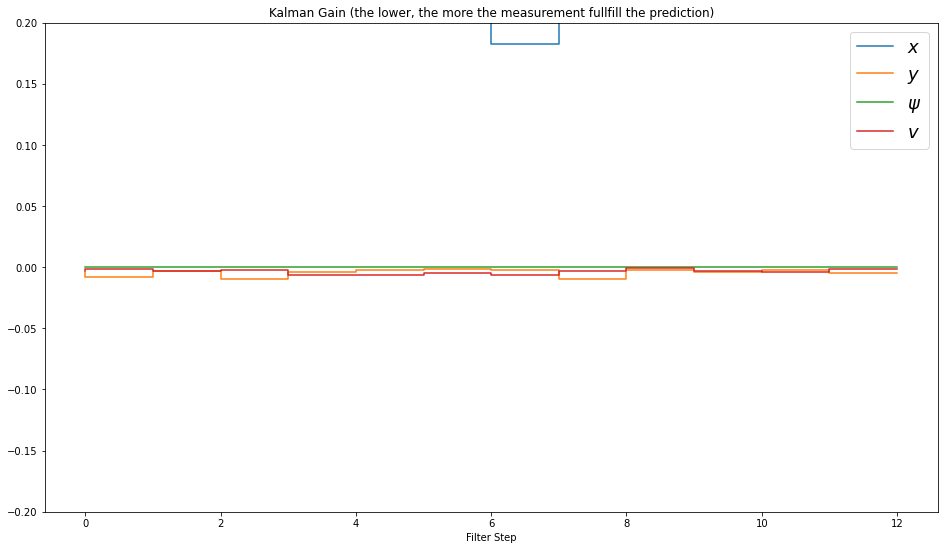

In [6]:
fig = plt.figure(figsize=(16,9))
plt.step(range(m),Kx, label='$x$')
plt.step(range(m),Ky, label='$y$')
plt.step(range(m),Kdx, label='$\psi$')
plt.step(range(m),Kdy, label='$v$')


plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.2,0.2]);

### Uncertainties

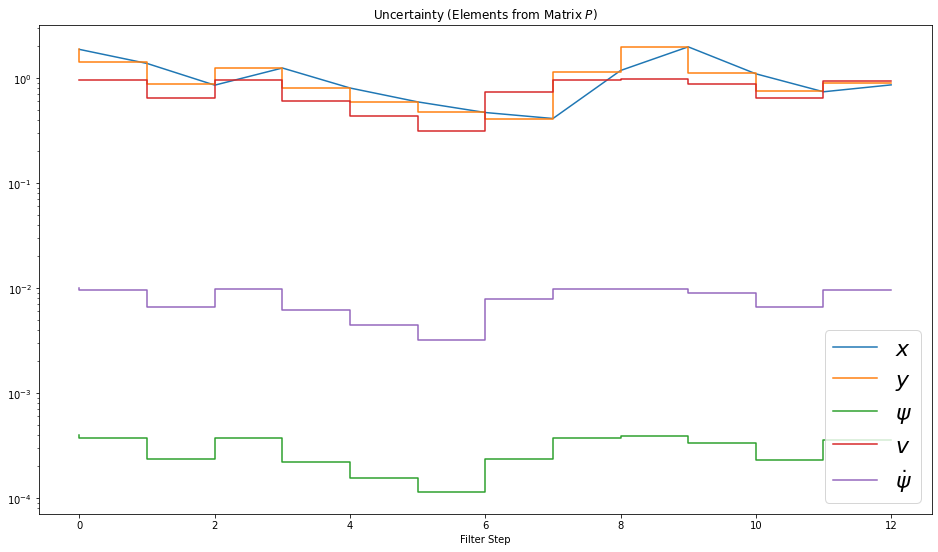

In [7]:

fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m),Py, label='$y$')
plt.step(range(m),Pdx, label='$\psi$')
plt.step(range(m),Pdy, label='$v$')
plt.step(range(m),Pddx, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

### Position x/y

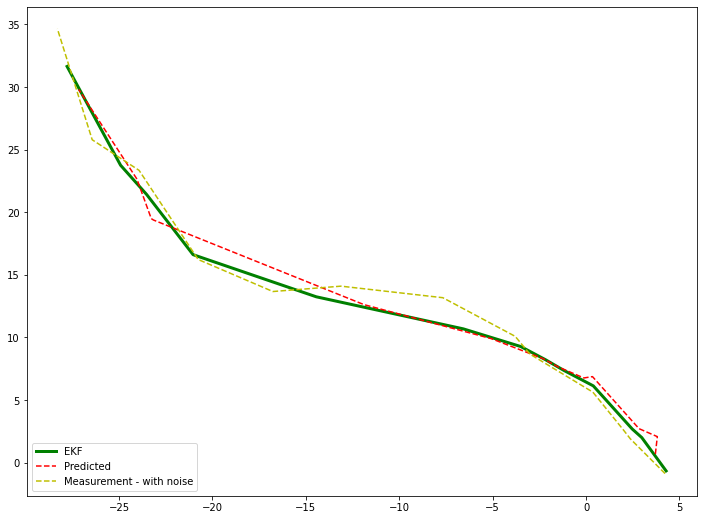

In [8]:
fig = plt.figure(figsize=(12,9))

x_measurement, y_measurement = mock[:, STATE_X_IDX], mock[:, STATE_Y_IDX]
x_noisy_measurement, y_noisy_measurement, x_predicted, y_predicted = np.array(
    [x_noisy_measurement, y_noisy_measurement, x_predicted, y_predicted],
    dtype='float64'
)

plt.plot(x0, x1, label='EKF', c='g', lw=3)
plt.plot(x_predicted, y_predicted, label='Predicted', c='r', lw=1.5, ls='--')

# plt.plot(x_measurement, y_measurement, label='Measurement - no noise', c='b', lw=1.5, ls=':')
plt.plot(x_noisy_measurement, y_noisy_measurement, label='Measurement - with noise', c='y', lw=1.5, ls='--')

plt.legend(loc="lower left")
plt.show()